In [1]:
import os
os.chdir('/home/research/yu.zihao/pnp/ESE513_Final_Project/')
print(os.getcwd())

/home/research/yu.zihao/pnp/ESE513_Final_Project


In [2]:
from pnp import pnp_admm
from pnp import pnp_admm_record_images
from utils import conv2d_from_kernel, compute_psnr, ImagenetDataset, myplot
import matplotlib.pyplot as plt
import PIL.Image as Image

In [3]:
# Get sample
test_image = Image.open('figs/brookings.webp').convert("RGB")
test_image = ImagenetDataset([]).test_transform(test_image)
# test_image = dataset[1231]['target'] # from dataset
channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0)
print(channels)
print(h)
print(w)

device = 'cpu' # BM3D packages seems to only suppot CPU

3
128
128


In [8]:
import torch
import bm3d
import numpy as np

def bm3d_denoiser(image_tensor: torch.Tensor, sigma=0.1):
    """
    BM3D denoiser that can handle both single images (3D tensors) and batches of images (4D tensors).
    
    Args:
        image_tensor (torch.Tensor): The noisy image tensor (B, C, H, W) or (C, H, W).
        sigma (float): Noise standard deviation (controls the amount of denoising).
        
    Returns:
        torch.Tensor: The denoised image as a PyTorch tensor with the same shape as the input.
    """
    # Check if the input is a PyTorch tensor
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    
    # Handle 4D tensor (batch of images) and 3D tensor (single image)
    if len(image_tensor.shape) == 4:  # Case for batch of images [B, C, H, W]
        batch_size, C, H, W = image_tensor.shape
        denoised_batch = []
        
        # Loop over each image in the batch and apply BM3D individually
        for i in range(batch_size):
            img = image_tensor[i]  # Get one image: [C, H, W]
            img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert to [H, W, C] for BM3D

            # Apply BM3D denoising to each channel independently
            denoised_np = np.zeros_like(img_np)
            for c in range(img_np.shape[2]):  # Loop over channels
                denoised_np[:, :, c] = bm3d.bm3d(img_np[:, :, c], sigma)

            # Convert the denoised image back to PyTorch tensor
            denoised_img = torch.tensor(denoised_np).permute(2, 0, 1).to(image_tensor.device)  # Back to [C, H, W]
            denoised_batch.append(denoised_img)

        # Stack the denoised images back into a batch: [B, C, H, W]
        return torch.stack(denoised_batch)

    elif len(image_tensor.shape) == 3:  # Case for single image [C, H, W]
        img_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to [H, W, C] for BM3D

        # Apply BM3D denoising to each channel independently
        denoised_np = np.zeros_like(img_np)
        for c in range(img_np.shape[2]):  # Loop over channels
            denoised_np[:, :, c] = bm3d.bm3d(img_np[:, :, c], sigma)

        # Convert the denoised image back to PyTorch tensor: [C, H, W]
        return torch.tensor(denoised_np).permute(2, 0, 1).to(image_tensor.device)

    else:
        raise ValueError("Input tensor must have either 3 (C, H, W) or 4 (B, C, H, W) dimensions.")


# It takes 3m 33.4s to run for single CPU. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06840561..1.0448847].


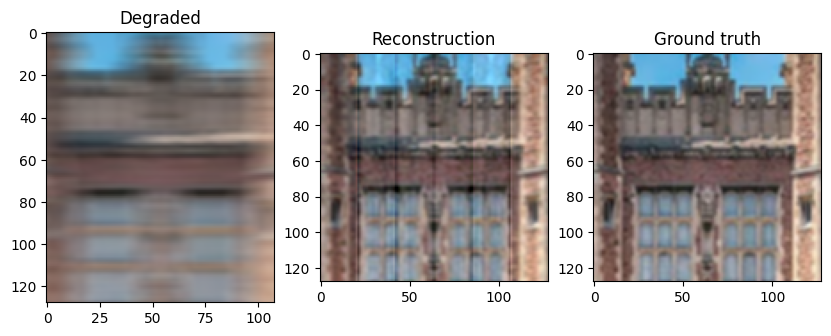

In [10]:
# Example usage with a single image
kernel_size = 21
kernel_motion_blur = torch.ones((1, kernel_size))
forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device)

y = forward(test_image)
denoised_image = pnp_admm(y, forward, forward_adjoint, bm3d_denoiser, num_iter=100, max_cgiter=30, cg_tol=1e-4)

# Display
myplot(y, denoised_image, test_image)